In [1]:
# imports
import pandas as pd
import os
import calendar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
df_lalonde = pd.read_csv('lalonde.csv').set_index('id')
df_lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
sns.set(color_codes=True)

# Question 1: Propensity score matching

### 1. A naive analysis
By looking at the data a  naive "researcher" might conclude that people who took part in the job training are more suceptible to earn more money in 1778 after the training

,treated,control
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


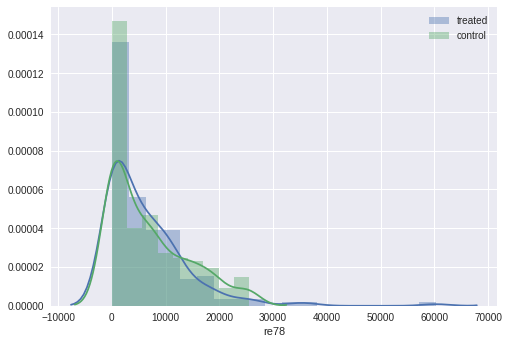

In [4]:
df_lalonde_treated = df_lalonde[df_lalonde.treat == 1]
df_lalonde_control = df_lalonde[df_lalonde.treat == 0]

#does a distplot makes sense in this situation (maybe an histogram would be better)
sns.distplot(df_lalonde_treated["re78"], label="treated")
sns.distplot(df_lalonde_control["re78"], label="control")
plt.legend()
df_summary = pd.DataFrame()
df_summary["treated"] = df_lalonde_treated["re78"].describe()
df_summary["control"] = df_lalonde_control["re78"].describe()
df_summary

### 2. A closer look at the data

In [5]:
def compare_feature(df,feature, ax=None):
    """Return a description of the feature conditioned on the treatement and plot
    the distribution of the data for the treatement and the control"""
    df_treated = df[df.treat == 1]
    df_control = df[df.treat == 0]
    sns.distplot(df_treated[feature], label="treated", ax=ax)
    sns.distplot(df_control[feature], label="control", ax=ax)
    plt.legend()
    df_summary = pd.DataFrame()
    df_summary[(feature, "treated")] = df_treated[feature].describe()
    df_summary[(feature, "control")] = df_control[feature].describe()
    df_summary.columns = pd.MultiIndex.from_tuples([(feature,'treated'),(feature,'control')], names=['feature', 'treat'])
    return df_summary
def get_features(df):
    features = list(df.columns)
    features.remove('treat')
    return features
def compare_all_feature(df):
    df_all_summary = pd.DataFrame()
    features = get_features(df)
    nb_col = 3
    nb_row = int(np.ceil(len(features)/nb_col))
    print(f'rows: {nb_row} & cols: {nb_col} for nb_feature: {len(features)}')
    fig, axes = plt.subplots(nb_row,nb_col, figsize=(20,20))
    for i, f in enumerate(features):
        df_temp = compare_feature(df, f, axes[int(i/nb_row), i%nb_col])
        df_all_summary = pd.concat([df_all_summary, df_temp], axis=1)
    
    return df_all_summary

rows: 3 & cols: 3 for nb_feature: 9


feature         age                    educ                   black  \
treat       treated     control     treated     control     treated   
count    185.000000  429.000000  185.000000  429.000000  185.000000   
mean      25.816216   28.030303   10.345946   10.235431    0.843243   
std        7.155019   10.786653    2.010650    2.855238    0.364558   
min       17.000000   16.000000    4.000000    0.000000    0.000000   
25%       20.000000   19.000000    9.000000    9.000000    1.000000   
50%       25.000000   25.000000   11.000000   11.000000    1.000000   
75%       29.000000   35.000000   12.000000   12.000000    1.000000   
max       48.000000   55.000000   16.000000   18.000000    1.000000   

feature                  hispan                 married              \
treat       control     treated     control     treated     control   
count    429.000000  185.000000  429.000000  185.000000  429.000000   
mean       0.202797    0.059459    0.142191    0.189189    0.512821   
std        0.402552    0.237124    0.349654    0.392722    0.500419   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.000000    0.000000    0.000000    0.000000    0.000000   
50%        0.000000    0.000000    0.000000    0.000000    1.000000   
75%        0.000000    0.000000    0.000000    0.000000    1.000000   
max        1.000000    1.000000    1.000000    1.000000    1.000000   

feature    nodegree                      re74                        re75  \
treat       treated     control       treated       control       treated   
count    185.000000  429.000000    185.000000    429.000000    185.000000   
mean       0.708108    0.596737   2095.573689   5619.236506   1532.055314   
std        0.455867    0.491126   4886.620353   6788.750796   3219.250870   
min        0.000000    0.000000      0.000000      0.000000      0.000000   
25%        0.000000    0.000000      0.000000      0.000000      0.000000   
50%        1.000000    1.000000      0.000000   2547.047000      0.000000   
75%        1.000000    1.000000   1291.468000   9277.128000   1817.284000   
max        1.000000    1.000000  35040.070000  25862.320000  25142.240000   

feature                        re78                
treat         control       treated       control  
count      429.000000    185.000000    429.000000  
mean      2466.484443   6349.143530   6984.169742  
std       3291.996183   7867.402218   7294.161791  
min          0.000000      0.000000      0.000000  
25%          0.000000    485.229800    220.181300  
50%       1086.726000   4232.309000   4975.505000  
75%       3881.419000   9642.999000  11688.820000  
max      18347.230000  60307.930000  25564.670000

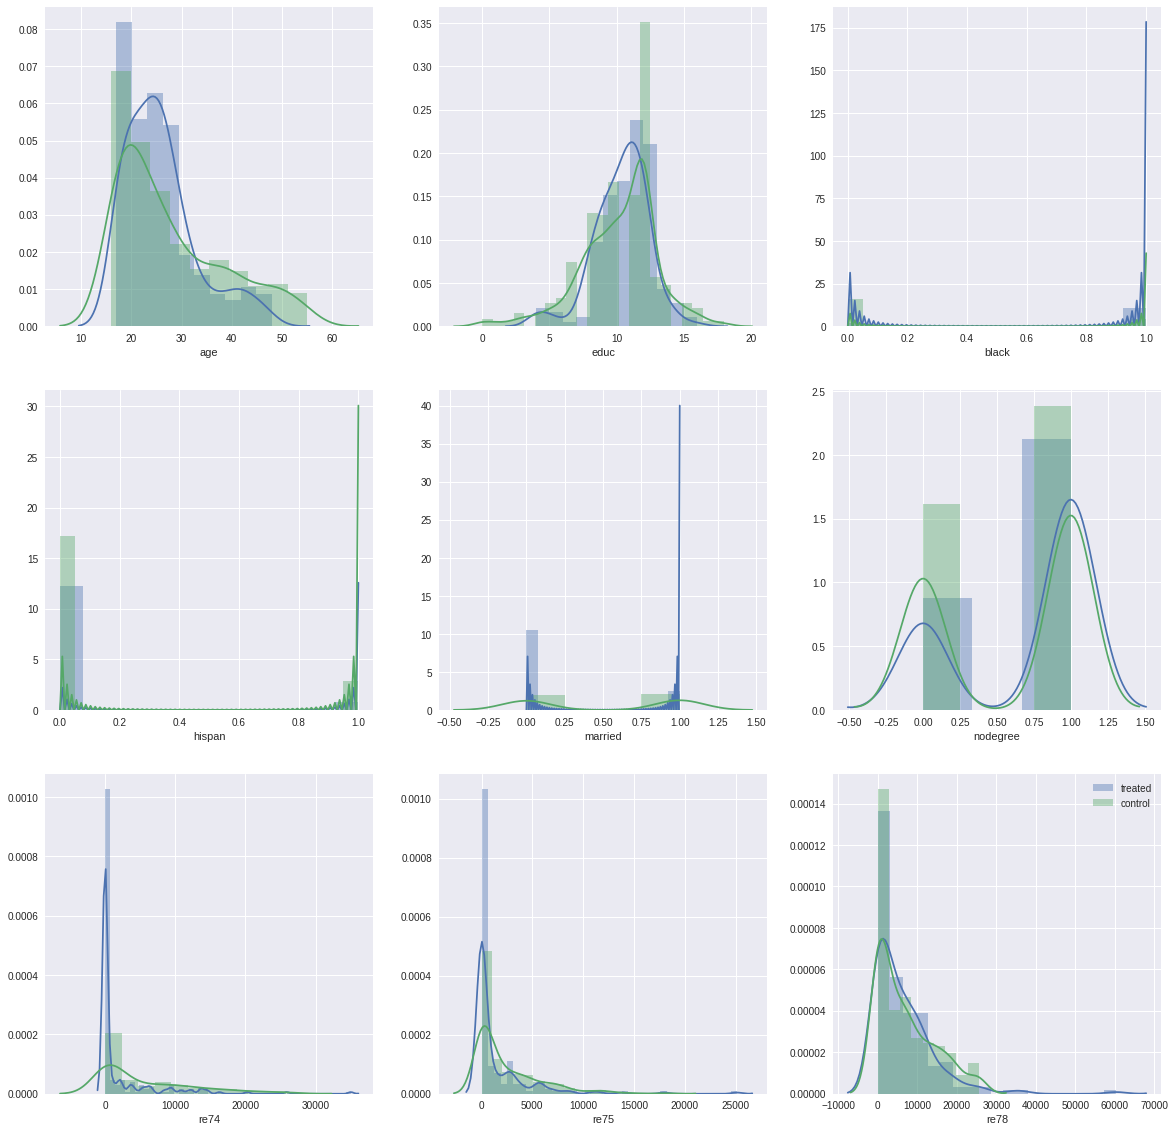

In [6]:
compare_all_feature(df_lalonde)

### 3. A propensity score model


In [7]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression(penalty='l1')

In [8]:
#finding the probaility of have receive the treatement given the covariate (features) (this is call the propensity score)
X = df_lalonde[get_features(df_lalonde)]
y = df_lalonde['treat']
logistic.fit(X, y)
df_lalonde['propensity'] = logistic.predict_proba(X)[:,1]
#df_lalonde['propensity2'] = logistic.predict(X)
print(f'The logistic regression score : {logistic.score(X, y)}')
df_lalonde.head()

The logistic regression score : 0.8159609120521173


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.606314
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.187379
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.789373
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.746070
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.672706


### 4. Balancing the dataset via matching


In [9]:
from munkres import Munkres
from scipy.optimize import linear_sum_assignment

In [10]:
def create_cost_matrix(treated, control):
    """ Return the cost matrix between the two arrays
        Each entry (i,j) in the cost matrix represent the distance from 
        node i to node j"""
    cost = np.zeros([len(treated), len(control)])
    for i, t in enumerate(treated):
        for j, c in enumerate(control):
            cost[i, j] = abs(t-c)
    return cost

def propensity_matching(df):
    """Return the treated and a subset of control composed from the 
    one matching between the closest point in the control dataset"""
    df_treated = df[df['treat']==1]
    df_control = df[df['treat']==0]
    cost_matrix = create_cost_matrix(df_treated['propensity'], df_control['propensity'])
    #m = Munkres()
    #match = dict(m.compute(cost_matrix))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    #index = [match[i] for i in range(len(match))]
    return pd.concat([df_treated, df_control.iloc[col_ind]])
    
i=120
df_balanced  = propensity_matching(df_lalonde)
df_balanced.iloc[[i, i+185]]

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
id,,,,,,,,,,,
NSW121,1,29,14,1,0,0,0,0.0,679.6734,17814.980,0.782474
PSID164,0,17,7,0,1,0,1,0.0,2082.1450,6460.621,0.190559


rows: 4 & cols: 3 for nb_feature: 10


feature         age                    educ                   black  \
treat       treated     control     treated     control     treated   
count    185.000000  185.000000  185.000000  185.000000  185.000000   
mean      25.816216   24.529730   10.345946   10.470270    0.843243   
std        7.155019   10.058548    2.010650    2.714781    0.364558   
min       17.000000   16.000000    4.000000    0.000000    0.000000   
25%       20.000000   18.000000    9.000000    9.000000    1.000000   
50%       25.000000   20.000000   11.000000   11.000000    1.000000   
75%       29.000000   28.000000   12.000000   12.000000    1.000000   
max       48.000000   55.000000   16.000000   18.000000    1.000000   

feature                 hispan                 married              \
treat      control     treated     control     treated     control   
count    185.00000  185.000000  185.000000  185.000000  185.000000   
mean       0.47027    0.059459    0.178378    0.189189    0.178378   
std        0.50047    0.237124    0.383870    0.392722    0.383870   
min        0.00000    0.000000    0.000000    0.000000    0.000000   
25%        0.00000    0.000000    0.000000    0.000000    0.000000   
50%        0.00000    0.000000    0.000000    0.000000    0.000000   
75%        1.00000    0.000000    0.000000    0.000000    0.000000   
max        1.00000    1.000000    1.000000    1.000000    1.000000   

feature    nodegree                      re74                        re75  \
treat       treated     control       treated       control       treated   
count    185.000000  185.000000    185.000000    185.000000    185.000000   
mean       0.708108    0.654054   2095.573689   2249.026492   1532.055314   
std        0.455867    0.476967   4886.620353   4247.349731   3219.250870   
min        0.000000    0.000000      0.000000      0.000000      0.000000   
25%        0.000000    0.000000      0.000000      0.000000      0.000000   
50%        1.000000    1.000000      0.000000    295.849300      0.000000   
75%        1.000000    1.000000   1291.468000   1822.118000   1817.284000   
max        1.000000    1.000000  35040.070000  21918.320000  25142.240000   

feature                        re78                propensity              
treat         control       treated       control     treated     control  
count      185.000000    185.000000    185.000000  185.000000  185.000000  
mean      1659.599971   6349.143530   6552.191675    0.573364    0.361990  
std       2718.784290   7867.402218   6455.447311    0.214294    0.249984  
min          0.000000      0.000000      0.000000    0.025502    0.025475  
25%          0.000000    485.229800    582.224300    0.517133    0.127266  
50%        320.467700   4232.309000   5495.665000    0.662321    0.219624  
75%       1890.581000   9642.999000  10122.430000    0.711011    0.647412  
max      13776.530000  60307.930000  25564.670000    0.930547    0.785440

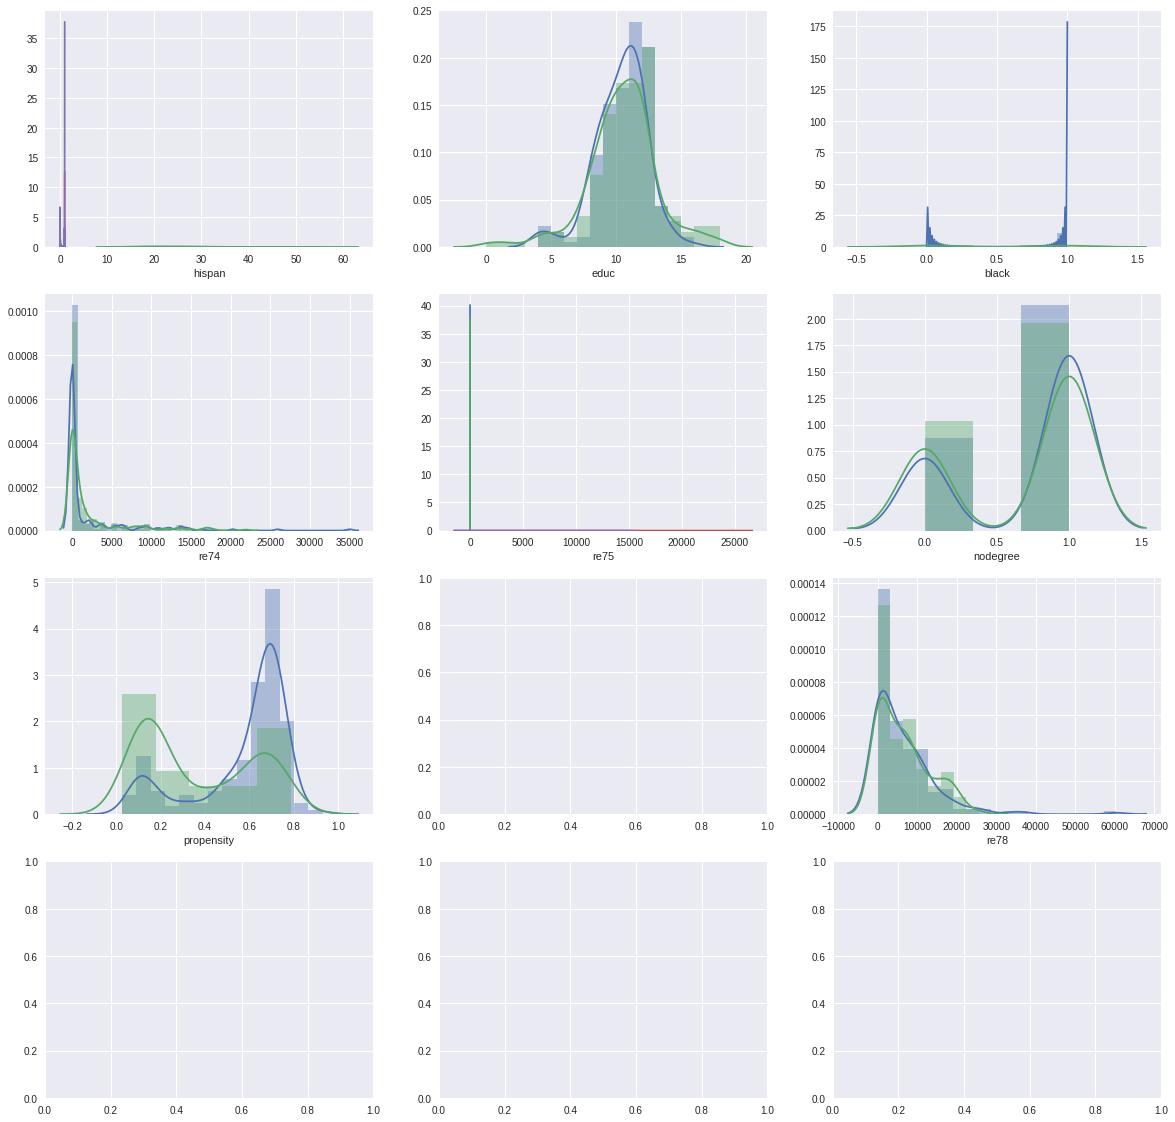

In [12]:
compare_all_feature(df_balanced)

### 5. Balancing the groups further
If there isn't any good enough matching for some point in the treated set to the control set then it is imposible to do better

Above a propensity score of 0.5, we have only 68 control observation and 140 treated observation


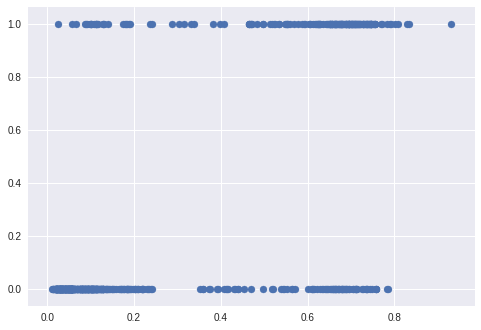

In [34]:
prop_score_threshold = 0.5
plt.scatter(df_lalonde['propensity'], df_lalonde['treat'])
length_treat = len(df_lalonde[(df_lalonde['propensity']>prop_score_threshold) & (df_lalonde['treat'] == 1)])
length_cont = (len(df_lalonde[(df_lalonde['propensity']>prop_score_threshold) & (df_lalonde['treat'] == 0)]))
print(f'Above a propensity score of {prop_score_threshold}, we have only {length_cont} \
control observation and {length_treat} treated observation')
## TODO more work is needed

### 6. A less naive analysis

- TODO...

# Question 2: Applied ML